In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import skimage as sk
from skimage import measure, filters

from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

# #load the libraries
from lib import *
from lib.routines.compute_bdrates import *
# from lib.measure._find_tips_pbc_cy import lookup_segments
# from lib.measure._find_tips_kernel import *
# from lib.measure._find_tips_kernel_cy import find_intersections
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

100000
Automatic calling is: Smart


# TODO: plot two nearby frames of tips and functionally link them

# find a nice theta_threshold

In [619]:
data_dir_log = os.path.join(nb_dir,'Figures/methods/tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv')
df = pd.read_csv(data_dir_log)
df['grad_u_mag'] = df['grad_ux']**2 + df['grad_uy']**2
df['grad_v_mag'] = df['grad_vx']**2 + df['grad_vy']**2
df['theta_comp'] = np.abs(np.pi/2-df['theta'])



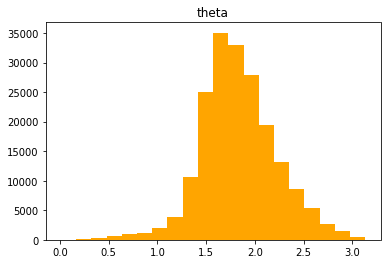

In [620]:
col = 'theta'
values = df[col].values
plt.hist(values,bins = 20, color='orange')
plt.title(col)
plt.show()

In [621]:
print(df.columns)
#summary statistics for each column
df.describe().T[[
    'min',
    'max'
]].T

Index(['t', 'n', 'x', 'y', 'theta', 'grad_ux', 'grad_uy', 'grad_vx', 'grad_vy',
       'v', 'f', 's', 'dvdt', 'dfdt', 'dsdt', 'grad_u_mag', 'grad_v_mag',
       'theta_comp'],
      dtype='object')


,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp
min,500.0,6.0,0.000001,0.000594,0.009657,-47421.204764,-98663.593328,-872126.015134,-120463.408507,0.236417,0.000003,0.670323,-0.007617,-0.015415,-0.001097,1.002346e+00,1.034120e+00,0.000003
max,1000.0,16.0,199.998907,199.997691,3.133060,71555.306143,60095.555167,41462.790237,565070.209264,0.598606,0.200864,0.877856,0.012283,-0.000000,-0.000838,1.142413e+10,1.079908e+12,1.562264


In [622]:
dg = df#.query('t < 1000')

theta_comp is the nonnegative angle complementary to theta


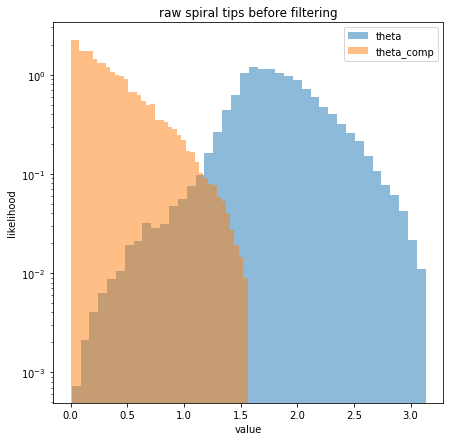

In [623]:
plt.figure(figsize=(7,7))
col_lst = ['theta', 'theta_comp']
print("theta_comp is the nonnegative angle complementary to theta")
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

In [624]:
1/np.sqrt(2)
theta_comp_threshold = 1*np.pi/3
print(f"please consider theta_comp_threshold = {theta_comp_threshold:.3f}...")
print(f"TODO: try tracking with some memory mem>=2.")

please consider theta_comp_threshold = 1.047...
TODO: try tracking with some memory mem>=2.


# visualize histograms of EP features (not clearly helpful to filtering)

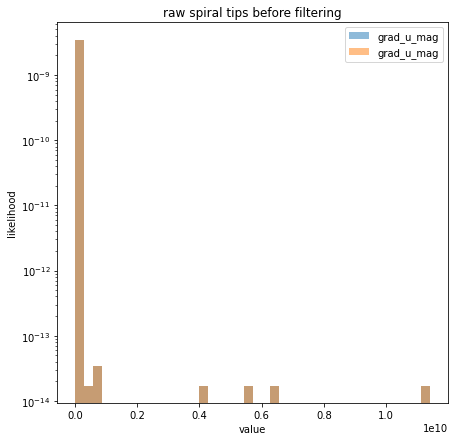

In [78]:
plt.figure(figsize=(7,7))
col_lst = ['grad_u_mag', 'grad_u_mag']
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

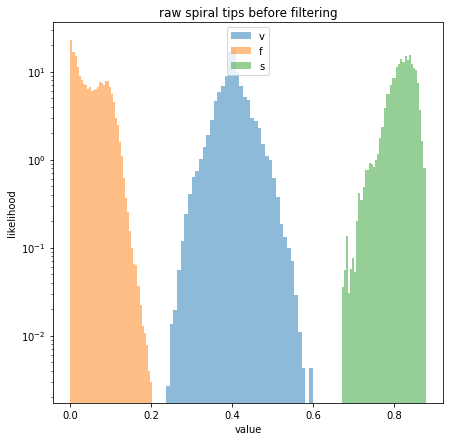

In [79]:
plt.figure(figsize=(7,7))
col_lst = ['v', 'f', 's'] 
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

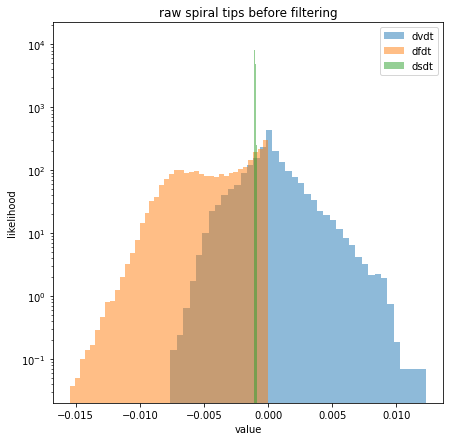

In [80]:
plt.figure(figsize=(7,7))
col_lst = ['dvdt', 'dfdt', 'dsdt']
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

In [45]:
#good sanity check but doesn't identify any bad tips here.
dsdt_thresh=-0.0007
print(f"It is {(df['dsdt']>dsdt_thresh).values.any()} that any unfiltered spiral tips were observed with dsdt>{dsdt_thresh}.")

It is False that any unfiltered spiral tips were observed with dsdt>-0.0007.


# TODO: consider tracking/filtering tips on the basis of moving in the direction of grad_u (or grad_v)
- TODO: see solution for automated tip detection
- TODO: visualize the histogram of angles between grad_u and the displacement between frames for each row resulting from ^that
- TODO: is there any bimodal distribution?  If not, consider variations on a them.  e.g., grad_v... np.cross... etc...

# DONE: try a DataFrame filter and view the resulting bdrates (on a histogram?)

In [752]:
data_dir_log = os.path.join(nb_dir,'Figures/methods/tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv')
df = pd.read_csv(data_dir_log)
df['grad_u_mag'] = df['grad_ux']**2 + df['grad_uy']**2
df['grad_v_mag'] = df['grad_vx']**2 + df['grad_vy']**2
df['theta_comp'] = np.abs(np.pi/2-df['theta'])

#(slow) assign each time a unique frame number
t_list =  sorted(set(df.t.values))
frameno_list = list(range(len(t_list)))
df['frame'] = -9999
for frameno, t in zip(frameno_list,t_list):
    df.loc[df.t==t, 'frame'] = frameno
#assert that all entries were given a value
assert ( not (df.frame<0).any() )

#first: use the trivial filter
# "tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv"
boo = [i is not None for i in df.index]
dg = df.loc[boo]

dh = dg.groupby('t').mean()[['n']]
dh.reset_index(inplace=True)

In [116]:
t_series = dh.t
n_series = dh.n

In [134]:
d = compute_bdrates(n_series,t_series).dropna()

In [137]:
d.describe()

,t,n,dn,rates
count,27.000000,27.000000,27.000000,27.000000
mean,791.401852,10.962963,0.074074,0.397100
std,153.404389,2.793970,2.036700,1.089967
min,527.125000,6.000000,-2.000000,0.011474
25%,664.612500,9.000000,-2.000000,0.036920
50%,814.800000,10.000000,2.000000,0.063898
75%,920.600000,13.000000,2.000000,0.290404
max,995.225000,16.000000,2.000000,5.714286


27
0.39710001958551644
1.0695924036783464


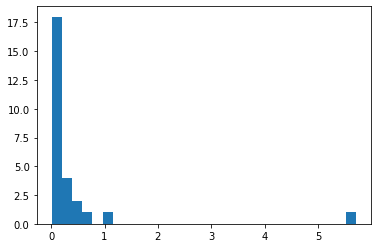

In [149]:
print(d.rates.values.size)
print(d.rates.values.mean())
print(d.rates.values.std())

plt.hist(d.rates.values, bins=30)
plt.show()

- DONE: visualize bdrates for a sanity check
- TODO: get generate_tip_logs_cy up and running
- TODO: start ^that on UB
- TODO: continue playing with filters here
- with (filtered) tip locations,
    - TODO: visualize bdrates
    - TODO: compute trajectories 
    - TODO: visualize MSD
    

In [176]:
t_series = dh.t
n_series = dh.n

20001


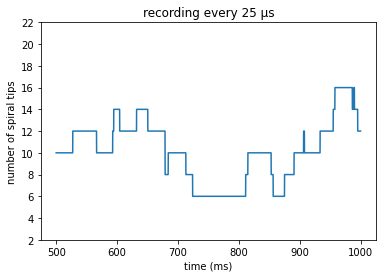

In [177]:
x_values = t_series.values
y_values = n_series.values

num_observations = len(x_values)
print(num_observations)

save = False
plt.plot(x_values,y_values)
plt.title(f"recording every 25 µs")
plt.xlabel(f"time (ms)")
plt.ylabel(f"number of spiral tips")
# ax.set_xticks([])
plt.yticks([2,4,6,8,10,12,14,16,18,20,22])
if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig(f"example_ic_200x200.120.32_num_tips_t_0_{t:.1}_V_{V_threshold}.png")
    #     plt.savefig('example_no_high_frequency_birth_deaths_t_500_600.png')

## visualize birth death rates

In [625]:
# #import data
# os.chdir(folder_name)
# df = pd.read_csv(file_out)

#drop termination times
# df.dropna(inplace=True)
# df = d.copy()

#drop rows with rates over 100/ms
# df = df.loc[df.rates<=1].copy()

# df = df.loc[df.rates<=0.02].copy()
# df = df.loc[df.rates<=0.1].copy()

def get_bdrate_plot_data(df):
    dn_list = sorted(set(df.dn.values))
    dn_list = [-2,2]

    np.mean(df.n.values)

    #compute median rates and IQR for the error bars corresponding to each category in dn_list
    errorbar_data_list = []
    for dn in dn_list:  
        #iterate over n for each dn
        df2 = df.loc[df.dn==dn].copy()
        n_list = sorted(set(df2.n.values))
        y_val_list = []
        y_err_1_list = []
        y_err_2_list = []
        for n in n_list:
            df3 = df2.loc[df2.n == n].copy()
            y_val, y_err_1, y_err_2 = df3.describe().T[['50%', '25%', '75%']].loc['rates'].values
            y_err_2 = float(y_err_2 - y_val)
            y_err_1 = float(y_val - y_err_1)
            y_val = float(y_val)
            y_val_list.append(y_val)
            y_err_1_list.append(y_err_1)
            y_err_2_list.append(y_err_2)
        # errorbar_data = (dn, n_list, y_val_list, y_err_1_list, y_err_2_list)
        errorbar_data = {'dn':dn, 
                         'n_list':n_list, 
                         'y_val_list':y_val_list, 
                         'y_err_1_list':y_err_1_list, 
                         'y_err_2_list':y_err_2_list
                        }
        errorbar_data_list.append(errorbar_data)    

    #retrieve scatter plot data points for each category in dn_list
    scatter_data_list = []
    for dn in dn_list:  
        df2 = df.loc[df.dn==dn].copy()
        x_values = df2.n.values
        y_values = df2.rates.values
        scatter_data = {'dn':dn, 
                         'x_values':x_values, 
                         'y_values':y_values, 
                        }
        scatter_data_list.append(scatter_data)

    #assign a color/label/other formatting to each category in dn_list
    color_list_raw = ['red', 'blue', 'green', 'orange', 'brown', 'purple']
    formatting_data_list = []
    for i, dn in enumerate(dn_list):
        formatting_data = {
            'dn': dn,
            'color': color_list_raw[i],
            'label':f'$W_{{{int(dn):+d}}}$'
        }
        formatting_data_list.append(formatting_data) 
    retval = formatting_data_list, scatter_data_list, errorbar_data_list, 
    return retval

formatting_data_list, scatter_data_list, errorbar_data_list = get_bdrate_plot_data(df=d)

In [626]:
assert (len(formatting_data_list) is len(scatter_data_list ))
assert (len(formatting_data_list) is len(errorbar_data_list))

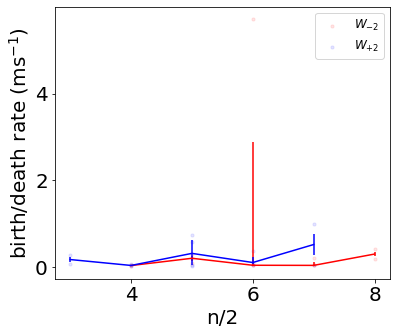

In [627]:
saving = False

savefig_dir = f'{nb_dir}/Figures/birth_death_analysis'
savefig_fn = 'birth_death_rates_ic2-from-log.png'
# savefig_fn = 'birth_death_rates_log.png'
log_scale = False
fontsize=20
figsize=(6,5)

# def birth_death_plot(*y_axis_struct_list):

# plot birth death rates with IQR y error bars with n on the x axis
fig, ax = plt.subplots(figsize=figsize)
for scatter_data, errorbar_data, formatting_data in zip(
    scatter_data_list, errorbar_data_list, formatting_data_list):

    dn, x_values, y_values = scatter_data.values()
    dn, n_list, y_val_list, y_err_1_list, y_err_2_list = errorbar_data.values()
    dn, color, label = formatting_data.values()
    yerr = np.array(list(zip(y_err_1_list,y_err_2_list))).T
    
    ax.scatter(x=x_values/2,y=y_values, c=color, s=10, alpha=0.1, label=label)
    ax.errorbar([n/2 for n in n_list], y_val_list, yerr=yerr, c=color)
    
# ax.legend(loc='top')

# ax.set_xticks([2,4,6,8, 10, 12])
# # ax.set_yticks([0,10,20,30,40,50])
# ymin, ymax = ax.get_ylim()
# ax.set_ylim((1e-3,0.4))

ax.legend(loc='best', fontsize= fontsize-8)
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_ylabel('birth/death rate (ms$^{-1}$)', fontsize=fontsize)
ax.set_xlabel('n/2', fontsize=fontsize) 
if log_scale:
    ax.set_yscale('log')
# ax.set_title(f'$\sigma = {sigma}$, threshold = {threshold}', fontsize=fontsize)
                    
# ax.set_title('high frequency birth deaths observed', fontsize=fontsize)
# ax.axis([20,60,0,7])
  
    
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")


In [628]:
# import trackpy
y_values.shape
# trackpy.link_iter?

(14,)

In [629]:
#the number when considering rates <= 0.1, we have
y_values.shape

(14,)

In [630]:
df.n.values.shape

(203282,)

In [631]:
df[(df.n%2==1)]

,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp


In [632]:
# from lib.birth_death_rates_from_ic import *
# initial_condition_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.33.npz'
# birth_death_rates_from_ic(initial_condition_dir)

# DONE: Test the full routine for generating tip logs

In [213]:
# from lib.routines.kwargs_cy import get_kwargs
# from lib.routines.generate_tip_logs_cy import generate_tip_logs_from_ic
# def run_routine(ic):
#     kwargs = get_kwargs(ic)
#     kwargs = generate_tip_logs_from_ic(ic, **kwargs)
#     return True
# # get_kwargs
# # generate_tip_logs_from_ic

# # ic = search_for_file()
# ic = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.32.npz'
# kwargs = get_kwargs(ic)

# kwargs['tmax'] = 100

# kwargs = generate_tip_logs_from_ic(ic, **kwargs)

# beep(3)

# DONE: filter df by theta and potentially more!

In [633]:
data_dir_log = os.path.join(nb_dir,'Figures/methods/tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv')
df = pd.read_csv(data_dir_log)
df['grad_u_mag'] = df['grad_ux']**2 + df['grad_uy']**2
df['grad_v_mag'] = df['grad_vx']**2 + df['grad_vy']**2
df['theta_comp'] = np.abs(np.pi/4-df['theta'])
dnaught = df.copy()


In [634]:
# input suggesting initial thresholds = "tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv"
theta_comp_threshold = np.pi/2.5 #1*np.pi/3 #np.pi/4  created aberrations #1/np.sqrt(2)#was too small
f_threshold = 0
#the trivial filter
boo = np.array([i is not None for i in df.index])

#the theta thresholded filter
boo &= (df.theta_comp<=theta_comp_threshold)

#TODO: consider an f threshold for small f_threshold.  There's a bunch near zero
boo &= df.f>0.01

#TODO: consider any other filters??

#compute birth death rates
dg = df.loc[boo]

#mean tip field DataFrame
# dg = dg.groupby('t').mean()[['n']]
# dg.reset_index(inplace=True)

#birth-death rates DataFrame
t_series = dg.t
n_series = dg.n
d = compute_bdrates(n_series,t_series).dropna()


109324


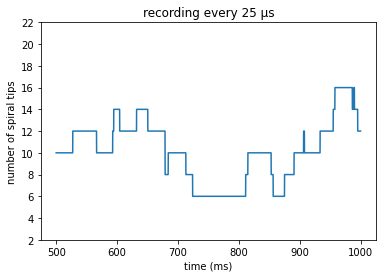

In [635]:
x_values = t_series.values
y_values = n_series.values

num_observations = len(x_values)
print(num_observations)

save = False
plt.plot(x_values,y_values)
plt.title(f"recording every 25 µs")
plt.xlabel(f"time (ms)")
plt.ylabel(f"number of spiral tips")
# ax.set_xticks([])
plt.yticks([2,4,6,8,10,12,14,16,18,20,22])
if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig(f"example_ic_200x200.120.32_num_tips_t_0_{t:.1}_V_{V_threshold}.png")
    #     plt.savefig('example_no_high_frequency_birth_deaths_t_500_600.png')

# TODO(finally): data science together a tip trajectory dataFrame for a given input_file_name of tip logs
- ^this might provide a new filter to robustly remove false tips!

In [636]:
print('the max bdrate is')
d.rates.describe()['max']

the max bdrate is


5.714285714283487

## TODO(refer to tip tracking .ipynb): track the tips using current trackpy implementation

In [637]:
import trackpy
dg.head()

,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp
0,500.0,10,1.797431,86.755323,1.971812,-0.388966,1.031992,-20.991924,1.446331,0.393947,0.069935,0.806118,0.000158,-0.005367,-0.001008,1.216302,442.752747,1.186414
3,500.0,10,40.851780,110.424705,1.833902,0.584281,1.154459,7.221990,-1.295690,0.381903,0.072489,0.852224,-0.002022,-0.005563,-0.001065,1.674160,53.835952,1.048504
4,500.0,10,54.879738,91.393116,1.697853,1.509588,0.692450,-0.642129,1.973307,0.422004,0.079982,0.810298,0.003837,-0.006138,-0.001013,2.758343,4.306270,0.912455
6,500.0,10,91.030156,65.441517,1.860444,0.631821,1.511874,5.967334,-5.892677,0.389288,0.099321,0.852280,0.003154,-0.007623,-0.001065,2.684961,70.332717,1.075046
7,500.0,10,93.586530,78.484654,1.590592,3.856218,-2.395161,0.761045,1.281898,0.386417,0.010750,0.792977,0.000252,-0.000825,-0.000991,20.607213,2.222452,0.805194


In [711]:
from lib.tracking import link
# retval = link(f=df, search_range=sr, pos_columns=None, t_column='frame', memory=0,
#         predictor=None, adaptive_stop=None, adaptive_step=0.95,
#         neighbor_strategy=None, link_strategy=None, dist_func=None,
#         to_eucl=None)

In [714]:
# track tips using periodic boundary conditions

# df_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.5_threshold_0.9_processed.csv'
# import sklearn
# df_dir = data_dir
# print(data_dir)
# df = pd.read_csv(df_dir)

df = dg
# mem = 2
# sr = 

#assign each time a unique frame number
t_list =  sorted(set(df.t.values))
frameno_list = list(range(len(t_list)))
df['frame'] = -9999
for frameno, t in zip(frameno_list,t_list):
    df.loc[df.t==t, 'frame'] = frameno
#assert that all entries were given a value
assert ( not (df.frame<0).any() )

#TODO: check that n is reproduced by the number of x in the trajectory file
# traj.query('t==555').t
# df['frame']




In [718]:
trackpy.link_df?

In [720]:
# h = 0.007
mem = 0
sr  = width+height #?works sampling every 100 frames
# sr  = 1 #works sampling every frame
distance_L2_pbc = get_distance_L2_pbc(width,height)
link_kwargs = {
    'neighbor_strategy' : 'BTree',
    'adaptive_step':0.5,
    'adaptive_stop': 1e-5,
    'dist_func'         : distance_L2_pbc,
    'memory': mem,
    'search_range':sr
}
# df['frame'] = np.around(df['t']/h)
# df = df.astype(dtype={'frame':int}).copy()


traj = trackpy.link_df(
    f=df,t_column='frame', **link_kwargs)

beep(2)

Frame 19997: 6 trajectories present.


0

In [715]:
#save ^that
# save_fn = os.path.basename(df_dir).replace('_processed.csv', f'_traj_sr_{sr}_mem_{mem}.csv')
# traj.to_csv(save_fn, index=False)
# print (save_fn)

beep(4)
traj.head()

,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp,frame,particle
0,500.0,10,1.797431,86.755323,1.971812,-0.388966,1.031992,-20.991924,1.446331,0.393947,0.069935,0.806118,0.000158,-0.005367,-0.001008,1.216302,442.752747,1.186414,0,0
3,500.0,10,40.851780,110.424705,1.833902,0.584281,1.154459,7.221990,-1.295690,0.381903,0.072489,0.852224,-0.002022,-0.005563,-0.001065,1.674160,53.835952,1.048504,0,1
4,500.0,10,54.879738,91.393116,1.697853,1.509588,0.692450,-0.642129,1.973307,0.422004,0.079982,0.810298,0.003837,-0.006138,-0.001013,2.758343,4.306270,0.912455,0,2
6,500.0,10,91.030156,65.441517,1.860444,0.631821,1.511874,5.967334,-5.892677,0.389288,0.099321,0.852280,0.003154,-0.007623,-0.001065,2.684961,70.332717,1.075046,0,3
7,500.0,10,93.586530,78.484654,1.590592,3.856218,-2.395161,0.761045,1.281898,0.386417,0.010750,0.792977,0.000252,-0.000825,-0.000991,20.607213,2.222452,0.805194,0,4


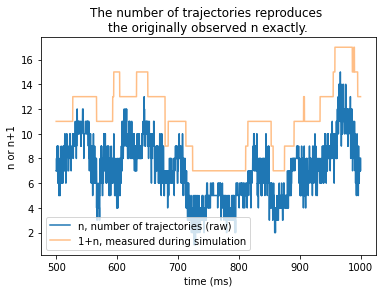

In [395]:
#plot spiral tip number versus time
# df = traj.copy()
#compute the number of spiral tips in each time frame
# df.groupby('t').describe().head()
n_series = traj['t'].value_counts().sort_index()
# plot tip number versus time for long-lived trajectories
x_values = n_series.index.values
y_values = n_series.values

##########################
plt.plot(x_values,y_values, label='n, number of trajectories (raw)')

# plot tip number versus time for all trajectories
t_values = df.t.values
n_values = df.n.values

##########################
plt.plot(t_values, n_values+1, alpha=0.5, label='1+n, measured during simulation')
plt.title("The number of trajectories reproduces \nthe originally observed n exactly.")
plt.xlabel('time (ms)')
plt.ylabel('n or n+1')
plt.legend()
plt.show()

#test that every row has a nonnegative particle number
assert ( (traj.particle>=0).all() )
# print ( save_fn ) 


The initial number of tips in `traj` versus `dnaught`

In [396]:
(traj.t<500.+0.024).values.sum()

7

In [397]:
(dnaught.t<500.+0.024).values.sum()

10

# this must be done "manually" (or with prior methods with "working" test cases). 
- DONE: plot the positions from first two frames in dnaught
- TODO: plot their plt.quiver arrows
- TODO: manually match the two frames
- TODO: compute displacements, plot via plt.quiver in different color
- TODO: compute the angles between these values
- TODO: repeat ^this for all frames
    - Do ^this by repeating the method (approximately)
- TODO: visualize the angle between the two colors of arrows using a histogram!
    - Do any robust thresholds appear?

## quiver plot the positions from first two frames in dnaught
- TODO(immediately): look for a solution for tip tracking with periodic boundary conditions

In [660]:
# ## practical test case for fast tip detection kernel
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
# txt = load_buffer(file)
# t   = 0. #ms


#load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
txt  = load_buffer(file)
t   = 500 #ms

V_threshold = 0.4
theta_threshold = 0.
level1 = V_threshold
level2 = 0.0

zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

contours1 = find_contours(img,    level = V_threshold)
contours2 = find_contours(dimgdt, level = 0.0)

In [661]:
#measure system with cython
#compute as discrete flow map dtexture_dt
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtxt_dt[...,0]

# find_intersections
lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = find_intersections(img,dimgdt,level1,level2)
x_values = np.array(lst_values_x)
y_values = np.array(lst_values_y)
# EP states given by bilinear interpolation with periodic boundary conditions
v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)

n_tips = x_values.size
dict_out = {
    't': float(t),
    'n': int(n_tips),
    'x': tuple(lst_values_x),
    'y': tuple(lst_values_y),
    'theta': tuple(lst_values_theta),
    'grad_ux': tuple(lst_values_grad_ux),
    'grad_uy': tuple(lst_values_grad_uy),
    'grad_vx': tuple(lst_values_grad_vx),
    'grad_vy': tuple(lst_values_grad_vy),
    'v':v_lst,
    'f':f_lst,
    's':s_lst,
    'dvdt':dvdt_lst,
    'dfdt':dfdt_lst,
    'dsdt':dsdt_lst,
}

In [662]:
(traj.t<500+2*0.025-0.001).values.sum()

12

In [663]:
(dnaught.t<500+2*0.025-0.001).values.sum()

20

In [664]:
dh = dnaught[(dnaught.t<500+2*0.025-0.001).values]
dh.head()

,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp
0,500.0,10,1.797431,86.755323,1.971812,-0.388966,1.031992,-20.991924,1.446331,0.393947,0.069935,0.806118,0.000158,-0.005367,-0.001008,1.216302,442.752747,1.186414
1,500.0,10,5.612069,40.878797,2.071288,0.687743,1.046119,-8.996704,2.376151,0.406868,0.001261,0.787299,0.001041,-0.000097,-0.000984,1.567355,86.586776,1.285890
2,500.0,10,35.278882,151.369661,1.930416,0.858636,1.032637,-1.011235,1.476774,0.398899,0.004692,0.814439,0.000425,-0.000360,-0.001018,1.803595,3.203458,1.145018
3,500.0,10,40.851780,110.424705,1.833902,0.584281,1.154459,7.221990,-1.295690,0.381903,0.072489,0.852224,-0.002022,-0.005563,-0.001065,1.674160,53.835952,1.048504
4,500.0,10,54.879738,91.393116,1.697853,1.509588,0.692450,-0.642129,1.973307,0.422004,0.079982,0.810298,0.003837,-0.006138,-0.001013,2.758343,4.306270,0.912455


In [665]:
tmin = dh.t.min()

#get the tips from time t and from the next timestep
t = t
h = 0.025 #ms
di = dh[dh.t==t]
x_values1 = di.x.values
y_values1 = di.y.values

#compute any other features desired for visualization
grad_ux = di.grad_ux.values
grad_uy = di.grad_uy.values
grad_vx = di.grad_vx.values
grad_vy = di.grad_vy.values
c_value1 = di.f

di = dh[(dh.t>t) & (dh.t<t+h+0.001)]
x_values2 = di.x.values
y_values2 = di.y.values
#compute any other features desired for visualization


In [679]:
h = 0.025
X  = x_values1
Y  = y_values1
Xp = x_values2
Yp = y_values2

#compute the velocities predicted by traj
dxdt = (Xp - X)/h
dydt = (Yp - Y)/h
speed = np.sqrt(dxdt**2 + dydt**2)
M = np.sqrt(dxdt**2 + dydt**2)
U = dxdt/M
V = dydt/M

#compute the unit gradient of u that is normal to the segment1
Mu = np.sqrt(grad_ux**2 + grad_uy**2)
Uu = grad_ux/Mu
Vu = grad_uy/Mu

#compute the unit gradient of v that is normal to the segment2
Mv = np.sqrt(grad_vx**2 + grad_vx**2)
Uv = grad_vx/Mv
Vv = grad_vy/Mv


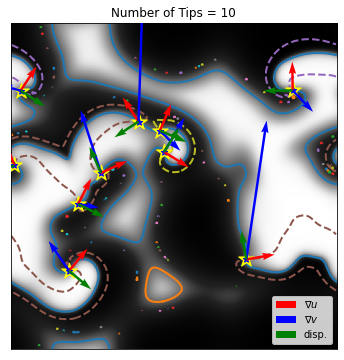

In [684]:
#TODO: plot these tips with their u's and v's
# Display the image and plot all pbc contours found properly!
save = False
printing = False
quiver_kwargs = {'alpha' : 1.,'zorder':100, 'units':'inches'}#, 'scale' : 2.5}

fig, ax = plt.subplots(figsize=(6,6))
# fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
# ax = axs[0]
ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=1, linestyle='-')
plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=1, linestyle='--')
# Q = 

#tips in current frame
ax.scatter(x=x_values1, y=y_values1, s=270, c='yellow', marker='*', zorder=3, alpha=1.)

#tips in coming frame
ax.scatter(x=x_values2, y=y_values2, s=45, c='blue', marker='*', zorder=3, alpha=1.)

Q = ax.quiver(X, Y, Uu, Vu, color='red',scale = 2.5, label=r'$\nabla u$', **quiver_kwargs)#, units='width'
# qk = ax.quiverkey(Q, 0.9, 0.9, 2, r'$\nabla u$', labelpos='E',coordinates='figure')
ax.quiver(X, Y, Uv, Vv, color='blue',scale = 2.5,label=r'$\nabla v$', **quiver_kwargs)#, units='width'
ax.quiver(X, Y, U, V, color='green',scale = 2.5, label='disp.', **quiver_kwargs)#, units='width'

# fig, ax = plt.subplots()
#arrows showing apparent displacement direction
# ax.set_title('Arrows scale with plot width, not view')
# Q = ax.quiver(X, Y, 100*U, 100*V, alpha = 0.5,label ='apparent disp.', zorder=100, units='inches')#, units='width'
# qk = ax.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')

ax.set_title(f"Number of Tips = {n_tips}")
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
# plt.show()
plt.legend()


if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    save_fn = f"tip_displacements_ic_200x200.120.32_t_{t:.3f}_V_{V_threshold}.png"
    plt.savefig(save_fn)
    print(f'figure saved in {save_fn}.')
if printing:
    residuals_x = np.array(sorted(x_values1))-np.array(sorted(x_values2))
    print('\ncomparing the two methods, the x coord of final tips has the following x displacements:')
    print(f"{ *residuals_x, }")
    
    residuals_y = np.array(sorted(y_values1))-np.array(sorted(y_values2))
    print('\ncomparing the two methods, the x coord of final tips has the following x displacements:')
    print(f"{ *residuals_y, }")
    
    #     print(sorted(lst_values_x))

In [ ]:



# fig, ax = plt.subplots()
# ax.set_title('Arrows scale with plot width, not view')
# Q = ax.quiver(X, Y, U, V, units='width', alpha = 0.5)
# # qk = ax.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
# #                    coordinates='figure')
# plt.show()

In [408]:
#TODO: manual tracking automation
np.array(sorted(x_values1))-np.array(sorted(x_values2))

array([ 0.010049, -0.006373, -0.008833, -0.007589,  0.000501,  0.021865,
       -0.008886, -0.003107,  0.000946,  0.013254])

In [685]:
speed_threshold = 2.
h = 0.025

#sorted tip coordinates make this an optimizing/improving condition
index1_lst = np.argsort(x_values1)
index2_lst = np.argsort(x_values2)

#sort x_values1,2 with an index map
lst_x1 = list(x_values1[index1_lst])
lst_y1 = list(y_values1[index1_lst])
lst_x2 = list(x_values2[index2_lst])
lst_y2 = list(y_values2[index2_lst])

lst_matches = []
# while lst_x1 is not []:
while len(lst_x1)>0:
    n_best = -1
    x1 = lst_x1.pop()
    y1 = lst_y1.pop()
    x2 = lst_x2[n_best]
    y2 = lst_y2[n_best]
    good = True
    
    #compute indices of the potential match
    i1 = int(np.argwhere(x1==x_values1))
    j1 = int(np.argwhere(y1==y_values1))
    #     i2 = int(np.argwhere(x2==x_values2))
    #     j2 = int(np.argwhere(y2==y_values2))
    #     assert(i2 is j2)
    
    ##test if good match.  See conditions below
    ##compute instantaneous measures
    #compute the speed directly
    spd = np.linalg.norm(np.array([[x2-x1],[y2-y1]]))/h
    good &= spd<=speed_threshold
    
    #compute the velocities predicted by traj
    # speed = np.sqrt(dxdt**2 + dydt**2) 
    # speed[i1]
    
    #compute the unit gradient of u that is normal to the segment1
    ux = grad_ux[i1]
    uy = grad_uy[i1]
    mu = np.sqrt(ux**2 + uy**2)
    nux = ux/mu
    nuy = uy/mu

    #compute the unit gradient of u that is normal to the segment1
    vx = grad_vx[i1]
    vy = grad_vy[i1]
    mv = np.sqrt(vx**2 + vy**2)
    nvx = vx/mu
    nvy = vy/mu
    

    
    #TODO: compute angle between 

    #         #compute marker specific data
    #     #         x1=lst_x1.pop(i1)
    #     #         x2=lst_x2[i1] 
    #             #plot that marker
    #             pass




    #         for i2 in np.argsort(x_values2):
    #             #         x2=lst_x2[i2]

    #             #TODO: if not ^that and previous speed was below a speed_threshold, verify that it has found the nearest match 

    #             #TODO(later): only do ^this check if 

    #             #TODO: compute the _pbc_distance between the two points

    
    if not good:
        #check if any other next_tip makes a closer/better match
        min_dist = spd # float(np.max((width,height)))
        n_better = -1
        for n,x2,y2 in enumerate(zip(x_values2,y_values2)): 
            #find match with smallest distance
            spdp = np.linalg.norm(np.array([[x2-x1],[y2-y1]]))/h
            boo_better = spdp<spd
            
            #compute any other conditionals
            
            if boo_better:
                n_better = n
                spd = spdp
                good = True
            #             good &= spd<=speed_threshold
            #TODO: compute dist
            
            #if dist<min_dist:
#                 update min_dist and friends with dist and friends
#             for if they match spiral tips
    if good:
        # remove the n_best match
        x2 = lst_x2.pop(n_best)
        y2 = lst_y2.pop(n_best)
        #TODO: record the match with indices i2 == j2
        i2 = int(np.argwhere(x2==x_values2))
        #         j2 = int(np.argwhere(y2==y_values2))
        #         assert(i2 is j2)
        lst_matches.append((i1,i2))
    else:
        pass
        #don'trecord the match


In [615]:
# TODO: seperately record any new tips if they exist
if len(lst_y2)>0:
    pass
    #add new tips as new trajectories.
    #record a dict_new_tips at these new tips and their next values
    #append dict_new_tips to lst_dict


In [567]:
#TODO: consider the absense of a tip nearby in the next frame as a damning condition for a 
#TODO: datascience the list of dict_new_tips.  Try to identify a feature distinguishing bad tips.

In [593]:
speed_threshold = 2.
h = 0.025

#sorted tip coordinates make this an optimizing/improving condition
index1_lst = np.argsort(x_values1)
index2_lst = np.argsort(x_values2)

#sort x_values1,2 with an index map
lst_x1 = list(x_values1[index1_lst])
lst_y1 = list(y_values1[index1_lst])
lst_x2 = list(x_values2[index2_lst])
lst_y2 = list(y_values2[index2_lst])


lst_matches = []
# while lst_x1 is not []:
while len(lst_x1)>0:
    n_best = -1
    x1 = lst_x1.pop()
    y1 = lst_y1.pop()
    x2 = lst_x2[n_best]
    y2 = lst_y2[n_best]
    
    # remove the n_best match
    x2 = lst_x2.pop(n_best)
    y2 = lst_y2.pop(n_best)
    print(x2)

172.395224
143.92543999999998
93.589637
91.03904200000001
77.87591
54.879236999999996
40.859369
35.287715000000006
5.618442
1.787382


TypeError: remove() takes no keyword arguments

In [591]:
lst_x2.pop(1)#n_best)

5.618442

In [616]:
#TODO: work out particle tracking
particle_counter = len(lst_x1)
particle_values1 = 
particle_values2 = 

SyntaxError: invalid syntax (<ipython-input-616-9606d5e70034>, line 3)

In [598]:
print(i2)
print(j2)
assert(i2 is j2)

9
9


# __TODO(time permitting): see old tracking routine using pbc enforcing distance__
__TODO(time permitting): see old tracking routine using pbc enforcing distance__


In [618]:
# __TODO(time permitting): see old tracking routine using pbc enforcing distance__


# track tips using periodic boundary conditions

In [722]:
# df_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/ds_5_param_set_8/Log/tip_log_ds_5_sigma_1.5_threshold_0.9_processed.csv'
# import sklearn
# df_dir = data_dir
# print(data_dir)
# df = pd.read_csv(df_dir)

df = dg

In [723]:
# #assign each time a unique frame number
# t_list =  sorted(set(df.t.values))
# frameno_list = list(range(len(t_list)))
# df['frame'] = -9999
# for frameno, t in zip(frameno_list,t_list):
#     df.loc[df.t==t, 'frame'] = frameno
# #assert that all entries were given a value
# assert ( not (df.frame<0).any() )

In [725]:
# np.mean(spd)*h
df.head()

,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp,frame
0,500.0,10,1.797431,86.755323,1.971812,-0.388966,1.031992,-20.991924,1.446331,0.393947,0.069935,0.806118,0.000158,-0.005367,-0.001008,1.216302,442.752747,1.186414,0
3,500.0,10,40.851780,110.424705,1.833902,0.584281,1.154459,7.221990,-1.295690,0.381903,0.072489,0.852224,-0.002022,-0.005563,-0.001065,1.674160,53.835952,1.048504,0
4,500.0,10,54.879738,91.393116,1.697853,1.509588,0.692450,-0.642129,1.973307,0.422004,0.079982,0.810298,0.003837,-0.006138,-0.001013,2.758343,4.306270,0.912455,0
6,500.0,10,91.030156,65.441517,1.860444,0.631821,1.511874,5.967334,-5.892677,0.389288,0.099321,0.852280,0.003154,-0.007623,-0.001065,2.684961,70.332717,1.075046,0
7,500.0,10,93.586530,78.484654,1.590592,3.856218,-2.395161,0.761045,1.281898,0.386417,0.010750,0.792977,0.000252,-0.000825,-0.000991,20.607213,2.222452,0.805194,0


In [749]:
#find the first odd tip
ntips_series = df.groupby('frame').frame.count()
(ntips_series.values%2==1).any()
frm_first_odd_tip = ntips_series[(ntips_series.values%2==1)].index[0]

In [750]:
df.loc[df.frame==frm_first_odd_tip]

,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp,frame
150,500.375,10,1.645408,86.699291,1.970774,-0.375128,1.031675,-17.331507,1.339212,0.407851,0.076418,0.810414,-0.000229,-0.005865,-0.001013,1.205074,302.174624,1.185376,15
153,500.375,10,40.961809,110.370310,1.730963,0.566021,1.161240,6.563957,-1.062471,0.373692,0.069049,0.851793,-0.002741,-0.005299,-0.001065,1.668858,44.214376,0.945565,15
154,500.375,10,54.872547,91.409871,1.688424,1.551911,0.666842,-0.596187,1.945707,0.422239,0.077439,0.809770,0.003600,-0.005943,-0.001012,2.853106,4.141215,0.903026,15
156,500.375,10,91.163789,65.381970,1.919325,0.674545,1.452448,5.919637,-5.840799,0.395027,0.093010,0.850999,0.001697,-0.007138,-0.001064,2.564616,69.157035,1.133927,15
157,500.375,10,93.633129,78.562353,1.591943,3.701176,-2.210451,0.741635,1.304451,0.390479,0.010189,0.791651,0.000198,-0.000782,-0.000990,18.584797,2.251615,0.806545,15
158,500.375,10,143.910919,144.458976,1.232888,1.653136,0.352289,0.212213,1.779244,0.376770,0.142497,0.872611,0.002876,-0.010936,-0.001091,2.856966,3.210744,0.447490,15
159,500.375,10,172.206696,40.784039,2.034810,-0.035308,5.391066,1.671114,-1.843379,0.479536,0.043113,0.821281,-0.002813,-0.003309,-0.001027,29.064839,6.190668,1.249412,15


In [751]:
dnaught.loc[dnaught.frame==frm_first_odd_tip]

AttributeError: 'DataFrame' object has no attribute 'frame'

In [755]:
# h = 0.007
mem = 2
sr  = 400#consider all tip pairs
width, height = txt.shape[:2]
distance_L2_pbc = get_distance_L2_pbc(width,height)

link_kwargs = {
    'neighbor_strategy' : 'BTree',
    'adaptive_step':0.5,
    'adaptive_stop': 1e-5,
    'dist_func'         : distance_L2_pbc,
    'memory': mem,
    'search_range':sr
}

# df['frame'] = np.around(df['t']/h)
# df = df.astype(dtype={'frame':int}).copy()
traj = trackpy.link_df(
    f=df,t_column='frame',**link_kwargs)

beep(1)

Frame 20000: 12 trajectories present.


0

In [756]:
#TODO: check that n is reproduced by the number of x in the trajectory file. as of now it doesn't :(
# traj.query('t==555').t
# df['frame']
data_folder = "/Users/timothytyree/Documents/GitHub/care/notebooks/Data/"
save_fn = os.path.join(data_folder,'test_trajectories.csv')
# input_file_dir.replace(f'_traj_sr_{sr}_mem_{mem}.csv')

In [757]:
# save_fn = os.path.basename(df_dir).replace('_processed.csv', 
print(save_fn)

/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_trajectories.csv


In [758]:
traj.to_csv(save_fn, index=False)
print (save_fn)

/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_trajectories.csv


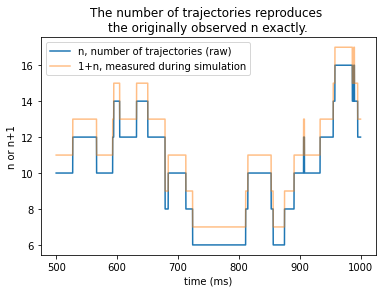

In [759]:
#plot spiral tip number versus time
# df = traj.copy()
#compute the number of spiral tips in each time frame
# df.groupby('t').describe().head()
n_series = traj['t'].value_counts().sort_index()
# plot tip number versus time for long-lived trajectories
x_values = n_series.index.values
y_values = n_series.values
plt.plot(x_values,y_values, label='n, number of trajectories (raw)')

# plot tip number versus time for all trajectories
t_values = df.t.values
n_values = df.n.values
plt.plot(t_values, n_values+1, alpha=0.5, label='1+n, measured during simulation')
plt.title("The number of trajectories reproduces \nthe originally observed n exactly.")
plt.xlabel('time (ms)')
plt.ylabel('n or n+1')
plt.legend()
plt.show()

In [269]:
#test that every row has a nonnegative particle number
assert ( (traj.particle>=0).all() )
print ( save_fn ) 

tip_log_ds_5_sigma_1.5_threshold_0.6_006_traj_sr_40_mem_2.csv


# TODO: for each trajectory visualize 
- line/scatter/errorbar plot MSD versus lag
- the histogram of angle between the three quiver arrows
- (later) fresh birth-death rates
- line plots of EP state evolution
    - do bad new tips follow a pattern?

In [761]:
#this one is good!!! look above!!!
traj.head()

,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp,frame,particle
0,500.0,10,1.797431,86.755323,1.971812,-0.388966,1.031992,-20.991924,1.446331,0.393947,0.069935,0.806118,0.000158,-0.005367,-0.001008,1.216302,442.752747,0.401016,0,0
1,500.0,10,5.612069,40.878797,2.071288,0.687743,1.046119,-8.996704,2.376151,0.406868,0.001261,0.787299,0.001041,-0.000097,-0.000984,1.567355,86.586776,0.500492,0,1
2,500.0,10,35.278882,151.369661,1.930416,0.858636,1.032637,-1.011235,1.476774,0.398899,0.004692,0.814439,0.000425,-0.000360,-0.001018,1.803595,3.203458,0.359620,0,2
3,500.0,10,40.851780,110.424705,1.833902,0.584281,1.154459,7.221990,-1.295690,0.381903,0.072489,0.852224,-0.002022,-0.005563,-0.001065,1.674160,53.835952,0.263106,0,3
4,500.0,10,54.879738,91.393116,1.697853,1.509588,0.692450,-0.642129,1.973307,0.422004,0.079982,0.810298,0.003837,-0.006138,-0.001013,2.758343,4.306270,0.127057,0,4


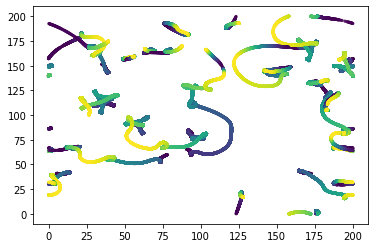

In [770]:
for pid in sorted(set(traj.particle.values)):
    p = traj.query(f'particle == {pid}')
    xv = p.x.values
    yv = p.y.values
    cv = p.frame.values
    plt.scatter(xv,yv,c=cv,s=5,alpha=0.8)
plt.show()

In [ ]:
for pid in sorted(set(traj.particle.values)):
    p = traj.query(f'particle == {pid}')
    xv = p.x.values
    yv = p.y.values
    cv = p.frame.values
    plt.scatter(xv,yv,c=cv,s=5,alpha=0.8)
plt.show()

In [848]:
# no brief particles (briefer than LT_thresh)
LT_thresh = 5000#1000#400
boo = traj['particle'].value_counts()>LT_thresh#.sort_index()>LT_thresh
# assert ( boo.values.all() ) 
lst_pid_long_enough = boo[boo].index.values

In [849]:
# boo_pid = ~np.array([v is not None for v in traj['particle'].values])

# for pid in lst_pid_long_enough:
#     boo_pid &= traj.particle==pid
# traj2 = traj[boo_pid]
# traj2

In [850]:
traj2 = pd.concat([traj.query(f'particle == {pid}') for pid in lst_pid_long_enough])

In [851]:
fps = 1/h*10**3 #frames per second
mpp = 5/200*10**4 #microns per pixel

In [852]:

# msd_series = trackpy.motion.emsd(traj,mpp=mpp, fps=fps)
msd_series = trackpy.motion.emsd(traj2,mpp=mpp, fps=fps)
x_values = msd_series.index.values*10**3
y_values = msd_series.values/10**6

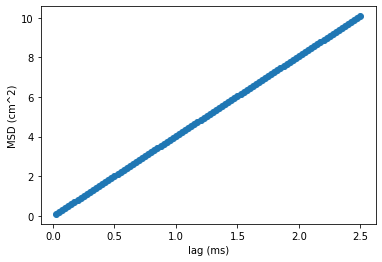

In [853]:
# plt.plot(msd_series.index.values,msd_series.values)
plt.scatter(x=x_values,y=y_values)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('lag (ms)')
plt.ylabel('MSD (cm^2)')
plt.show()

In [857]:
msd_series.index.values

array([2.500e-05, 5.000e-05, 7.500e-05, 1.000e-04, 1.250e-04, 1.500e-04,
       1.750e-04, 2.000e-04, 2.250e-04, 2.500e-04, 2.750e-04, 3.000e-04,
       3.250e-04, 3.500e-04, 3.750e-04, 4.000e-04, 4.250e-04, 4.500e-04,
       4.750e-04, 5.000e-04, 5.250e-04, 5.500e-04, 5.750e-04, 6.000e-04,
       6.250e-04, 6.500e-04, 6.750e-04, 7.000e-04, 7.250e-04, 7.500e-04,
       7.750e-04, 8.000e-04, 8.250e-04, 8.500e-04, 8.750e-04, 9.000e-04,
       9.250e-04, 9.500e-04, 9.750e-04, 1.000e-03, 1.025e-03, 1.050e-03,
       1.075e-03, 1.100e-03, 1.125e-03, 1.150e-03, 1.175e-03, 1.200e-03,
       1.225e-03, 1.250e-03, 1.275e-03, 1.300e-03, 1.325e-03, 1.350e-03,
       1.375e-03, 1.400e-03, 1.425e-03, 1.450e-03, 1.475e-03, 1.500e-03,
       1.525e-03, 1.550e-03, 1.575e-03, 1.600e-03, 1.625e-03, 1.650e-03,
       1.675e-03, 1.700e-03, 1.725e-03, 1.750e-03, 1.775e-03, 1.800e-03,
       1.825e-03, 1.850e-03, 1.875e-03, 1.900e-03, 1.925e-03, 1.950e-03,
       1.975e-03, 2.000e-03, 2.025e-03, 2.050e-03, 